In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/LabProject')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Function to calculate statistics
def calculate_statistics(data):
    return {
        "mean": data.mean(),
        "median": data.median(),
        "q1": data.quantile(0.25),
        "q2": data.median(),  # Same as median
        "q3": data.quantile(0.75)
    }

# Carica i due file CSV
file1 = 'image/cholect_annotation/IoU/iou_mask_bbox.csv'
file2 = 'image/cholect_annotation/IoU/iou_center_pts_bbox.csv'
file3 = 'image/cholect_annotation/IoU/iou_three_pts_bbox.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

print(df1.columns)
print(df2.columns)
print(df3.columns)

Index(['image', 'class', 'iou', 'is_similar'], dtype='object')
Index(['image', 'class', 'iou', 'is_similar'], dtype='object')
Index(['image', 'class', 'iou', 'is_similar'], dtype='object')


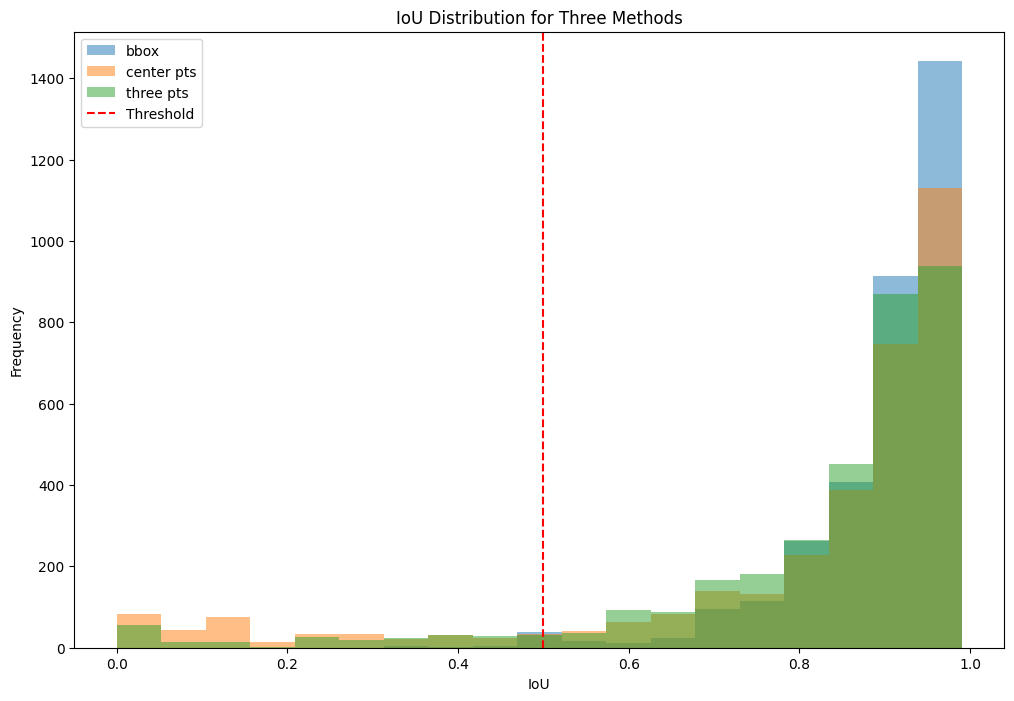

Statistiche delle IoU:
{'mean': iou_method1    0.898718
iou_method2    0.802710
iou_method3    0.824324
dtype: float64, 'median': iou_method1    0.929371
iou_method2    0.908669
iou_method3    0.895854
dtype: float64, 'std_dev': iou_method1    0.093350
iou_method2    0.243908
iou_method3    0.194602
dtype: float64}
Percentuale sopra soglia 0.5:
{'bbox': 99.0119760479042, 'center pts': 88.62275449101796, 'three pts': 92.93413173652695}
Metodo migliore in più casi:
best_method
iou_method1    1905
iou_method2     801
iou_method3     634
Name: count, dtype: int64


In [ ]:
# Unire i tre DataFrame per confronto
merged_df = pd.merge(df1, df2, on=["image", "class"], suffixes=("_method1", "_method2"))
merged_df = pd.merge(merged_df, df3, on=["image", "class"])
merged_df.rename(columns={"iou": "iou_method3"}, inplace=True)

# Calcolare differenze tra IoU
merged_df["iou_diff_1_2"] = merged_df["iou_method1"] - merged_df["iou_method2"]
merged_df["iou_diff_1_3"] = merged_df["iou_method1"] - merged_df["iou_method3"]
merged_df["iou_diff_2_3"] = merged_df["iou_method2"] - merged_df["iou_method3"]

# Statistiche sulle IoU
stats = {
    "mean": merged_df[["iou_method1", "iou_method2", "iou_method3"]].mean(),
    "median": merged_df[["iou_method1", "iou_method2", "iou_method3"]].median(),
    "std_dev": merged_df[["iou_method1", "iou_method2", "iou_method3"]].std()
}

# Percentuale di maschere sopra una soglia IoU
threshold = 0.5
above_threshold = {
    "bbox": (merged_df["iou_method1"] > threshold).mean() * 100,
    "center pts": (merged_df["iou_method2"] > threshold).mean() * 100,
    "three pts": (merged_df["iou_method3"] > threshold).mean() * 100,
}

# Confronto: quale metodo è il migliore più spesso
merged_df["best_method"] = merged_df[["iou_method1", "iou_method2", "iou_method3"]].idxmax(axis=1)
best_counts = merged_df["best_method"].value_counts()

# Calcola i limiti comuni per l'intervallo dei bin
min_value = min(merged_df["iou_method1"].min(), merged_df["iou_method2"].min(), merged_df["iou_method3"].min())
max_value = max(merged_df["iou_method1"].max(), merged_df["iou_method2"].max(), merged_df["iou_method3"].max())

# Definisci un array di bin uniforme
bins = np.linspace(min_value, max_value, 20)  # 20 bin uguali per tutti


# Visualizzare distribuzioni delle IoU
plt.figure(figsize=(12, 8))
plt.hist(merged_df["iou_method1"], bins=bins, alpha=0.5, label="bbox")
plt.hist(merged_df["iou_method2"], bins=bins, alpha=0.5, label="center pts")
plt.hist(merged_df["iou_method3"], bins=bins, alpha=0.5, label="three pts")
plt.axvline(x=threshold, color='r', linestyle='--', label="Threshold")
plt.title("IoU Distribution for Three Methods")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("iou_distribution_comparison_2.png")
plt.show()

# Risultati a schermo
print(f"Statistiche delle IoU:\n{stats}")
print(f"Percentuale sopra soglia {threshold}:\n{above_threshold}")
print(f"Metodo migliore in più casi:\n{best_counts}")

In [36]:
# Conta il numero di elementi per ogni classe
class_counts = merged_df["class"].value_counts()

print(class_counts)

class
grasper      2834
hook          382
bipolar        57
irrigator      31
clipper        27
scissors        9
Name: count, dtype: int64


In [ ]:
# Unique classes
classes = merged_df["class"].unique()

classes

array(['grasper', 'hook', 'irrigator', 'clipper', 'bipolar', 'scissors'],
      dtype=object)

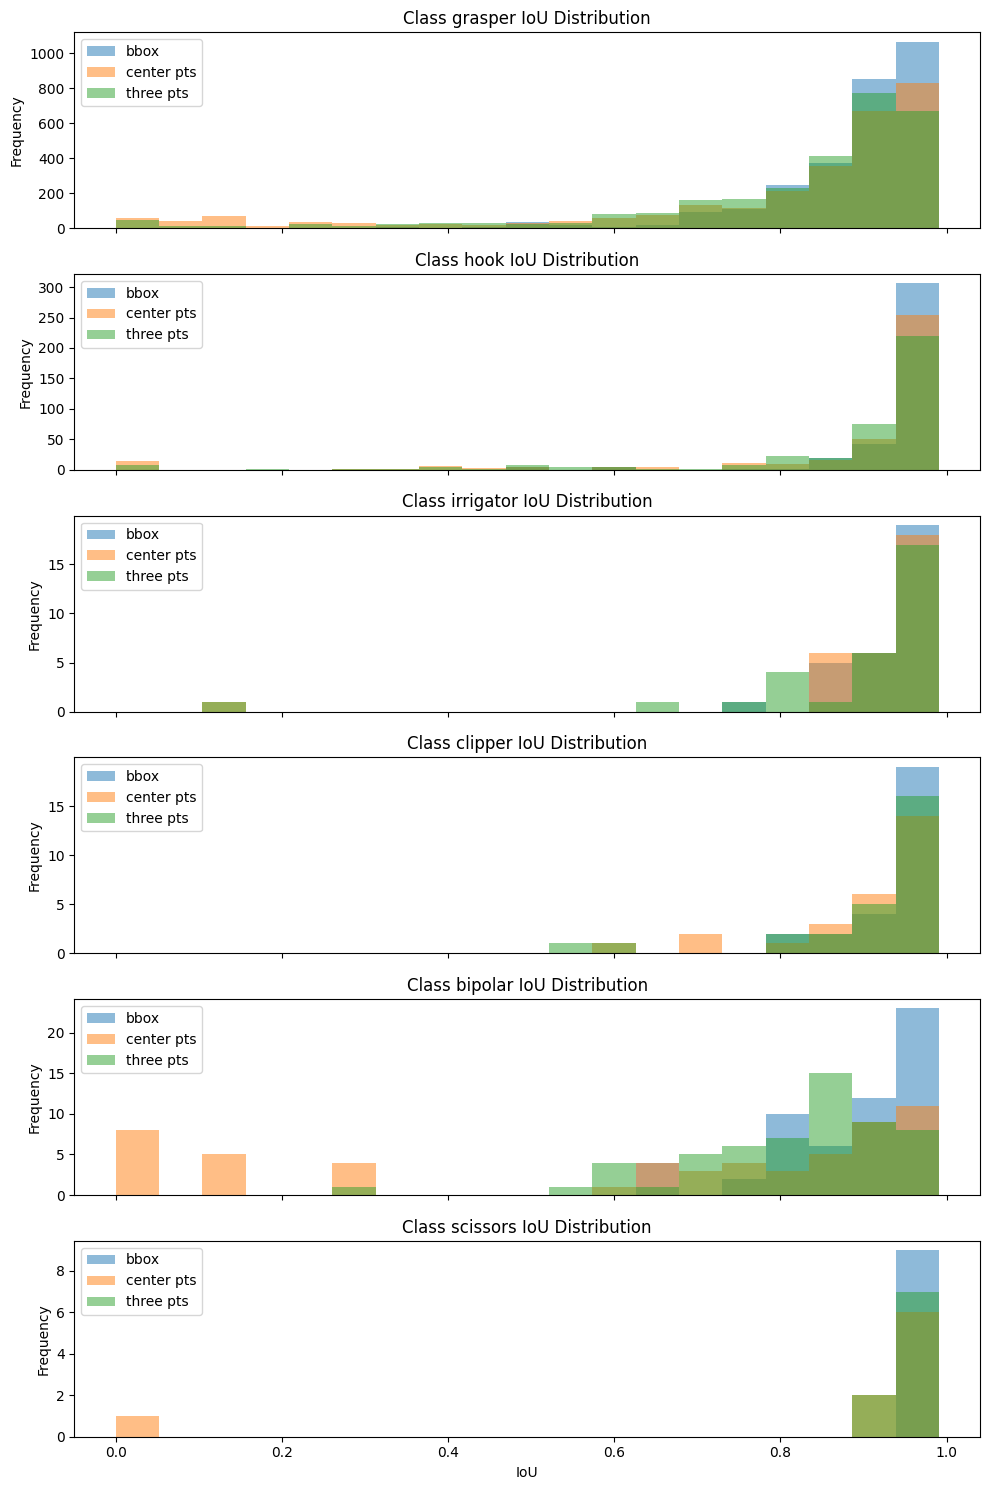

In [ ]:
# Create subplots
fig, axes = plt.subplots(len(classes), 1, figsize=(10, 15), sharex=True)

# Loop over each class and plot
for idx, cls in enumerate(classes):
    class_data = merged_df[merged_df["class"] == cls]

    # Plot histograms for IoU of each method
    axes[idx].hist(class_data["iou_method1"], bins=bins, alpha=0.5, label="bbox")
    axes[idx].hist(class_data["iou_method2"], bins=bins, alpha=0.5, label="center pts")
    axes[idx].hist(class_data["iou_method3"], bins=bins, alpha=0.5, label="three pts")

    # Add titles and labels
    axes[idx].set_title(f"Class {cls} IoU Distribution")
    axes[idx].set_ylabel("Frequency")
    axes[idx].legend()

# Set common X-axis label
plt.xlabel("IoU")
plt.tight_layout()
plt.savefig("classwise_iou_comparison_2.png")
plt.show()

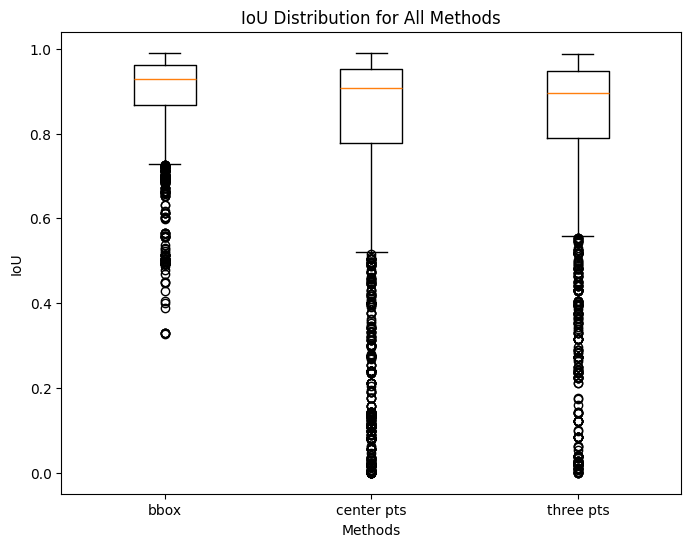

In [ ]:
# Create a general box plot
data = [
    merged_df["iou_method1"],
    merged_df["iou_method2"],
    merged_df["iou_method3"]
]

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=["bbox", "center pts", "three pts"])
plt.title("IoU Distribution for All Methods")
plt.ylabel("IoU")
plt.xlabel("Methods")
plt.savefig("iou_boxplot_comparison_2.png")
plt.show()

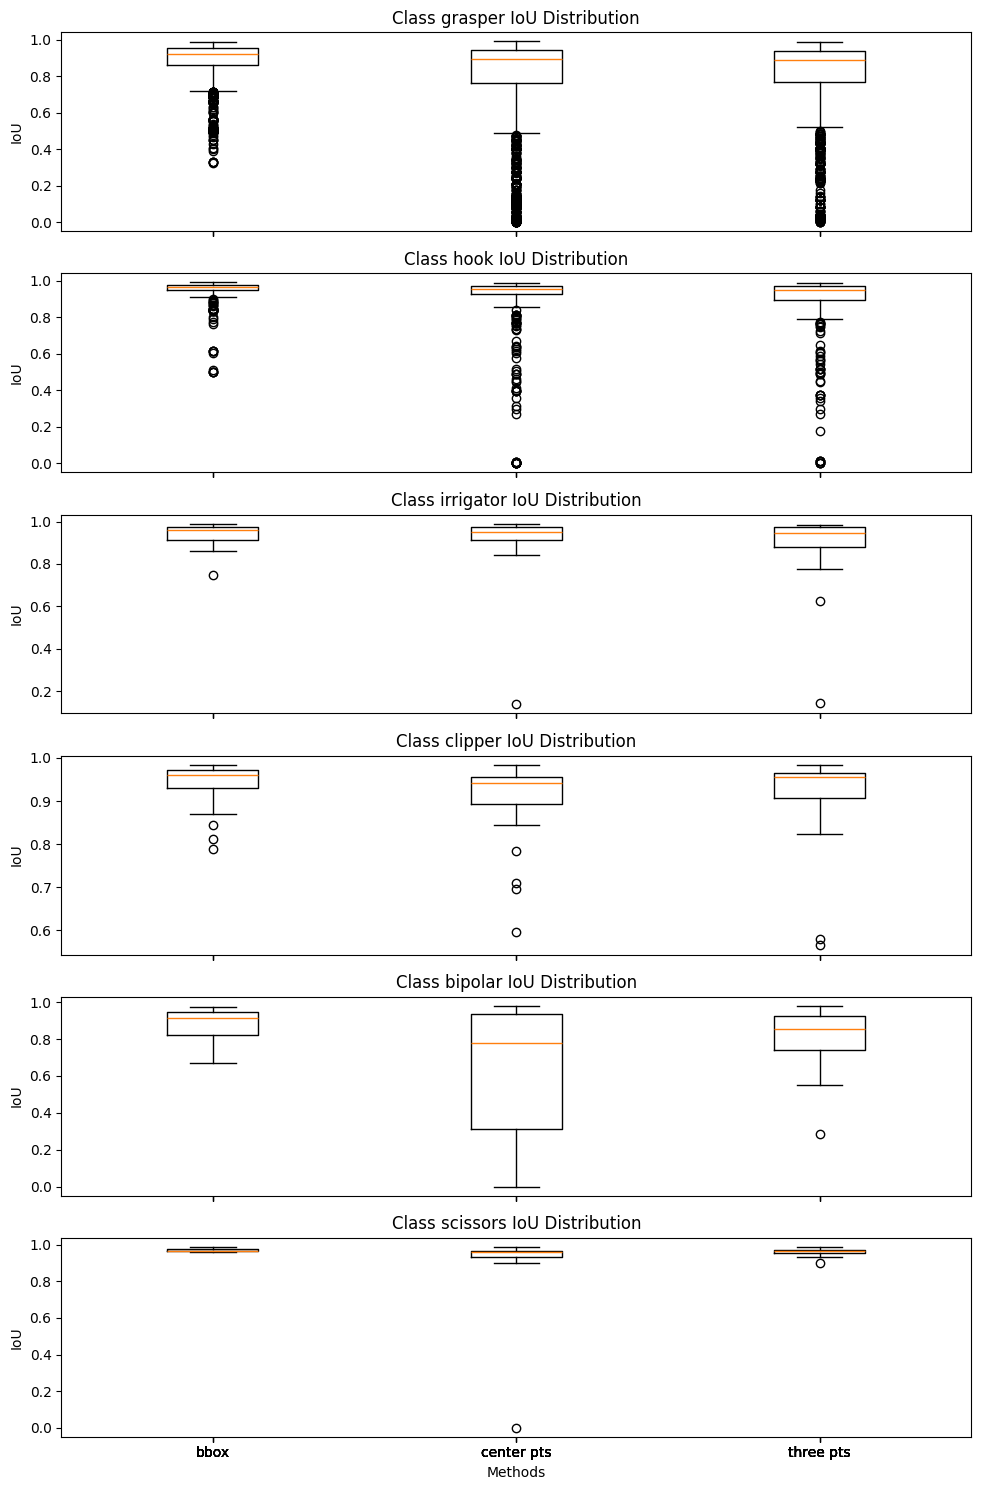

In [ ]:
all_stats = {}
# Create subplots for class-wise box plots
fig, axes = plt.subplots(len(classes), 1, figsize=(10, 15), sharex=True)

# Loop through classes to create box plots
for idx, cls in enumerate(classes):
    class_data = merged_df[merged_df["class"] == cls]
    data = [
        class_data["iou_method1"],
        class_data["iou_method2"],
        class_data["iou_method3"]
    ]

    # Calculate statistics for each method
    class_stats = {}
    for method_idx, method_data in enumerate(data):
        class_stats[f"Method {method_idx + 1}"] = calculate_statistics(method_data)

    all_stats[f"Class {cls}"] = class_stats

    axes[idx].boxplot(data, labels=["bbox", "center pts", "three pts"])
    axes[idx].set_title(f"Class {cls} IoU Distribution")
    axes[idx].set_ylabel("IoU")

# Set common X-axis label
plt.xlabel("Methods")
plt.tight_layout()
plt.savefig("classwise_iou_boxplot_comparison_2.png")
plt.show()

In [ ]:
# Display statistics
for cls, stats in all_stats.items():
    print(f"Statistics for {cls}:")
    for method, values in stats.items():
        print(f"  {method}:")
        print(f"    Mean IoU: {values['mean']:.4f}")
        print(f"    Median IoU: {values['median']:.4f}")
        print(f"    Q1 (25%): {values['q1']:.4f}")
        print(f"    Q2 (50%): {values['q2']:.4f}")
        print(f"    Q3 (75%): {values['q3']:.4f}")
    print()

Statistics for Class grasper:
  Method 1:
    Mean IoU: 0.8918
    Median IoU: 0.9217
    Q1 (25%): 0.8597
    Q2 (50%): 0.9217
    Q3 (75%): 0.9556
  Method 2:
    Mean IoU: 0.7938
    Median IoU: 0.8962
    Q1 (25%): 0.7610
    Q2 (50%): 0.8962
    Q3 (75%): 0.9452
  Method 3:
    Mean IoU: 0.8151
    Median IoU: 0.8893
    Q1 (25%): 0.7672
    Q2 (50%): 0.8893
    Q3 (75%): 0.9366

Statistics for Class hook:
  Method 1:
    Mean IoU: 0.9444
    Median IoU: 0.9649
    Q1 (25%): 0.9463
    Q2 (50%): 0.9649
    Q3 (75%): 0.9753
  Method 2:
    Mean IoU: 0.8771
    Median IoU: 0.9569
    Q1 (25%): 0.9244
    Q2 (50%): 0.9569
    Q3 (75%): 0.9713
  Method 3:
    Mean IoU: 0.8806
    Median IoU: 0.9492
    Q1 (25%): 0.8951
    Q2 (50%): 0.9492
    Q3 (75%): 0.9685

Statistics for Class irrigator:
  Method 1:
    Mean IoU: 0.9364
    Median IoU: 0.9593
    Q1 (25%): 0.9140
    Q2 (50%): 0.9593
    Q3 (75%): 0.9732
  Method 2:
    Mean IoU: 0.9098
    Median IoU: 0.9529
    Q1 (25%): 0.9138